In [ ]:
# The code was removed by Watson Studio for sharing.

<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In [2]:
! @hidden
username="wnmills3@gmail.com"
password="VDR34efc"

/usr/bin/sh: @hidden: command not found


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [164]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [165]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-01-07 21:16:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2021-01-07 21:16:28 (12.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [166]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [167]:
df.shape

(346, 10)

### Convert to date time object 

In [168]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [169]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [170]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

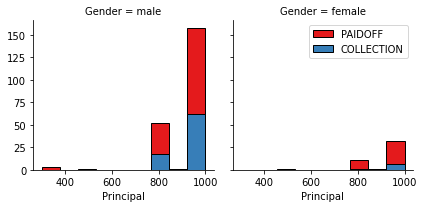

In [171]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

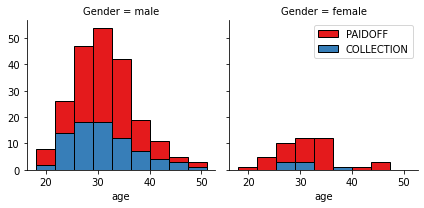

In [172]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

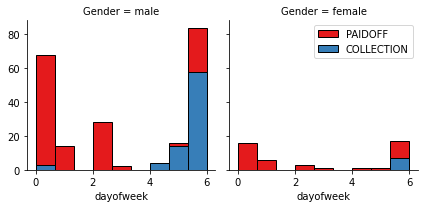

In [173]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [174]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [175]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [176]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [177]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [178]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [179]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [184]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [185]:
# create a numeric representation of the target label used by some models
df = df.assign(loan_state=df['loan_status'])
y = df['loan_status'].values
#print(y[0:5])
yy = df['loan_state']
#print(yy[0:5])
df['loan_state'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
#print(yy[0:5])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,loan_state
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,0


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [188]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [189]:
#set up test/train data
from sklearn.model_selection import train_test_split
# note: switch from categorical to binary test for target value (yy)
X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)
#print(y_test[0:5])
#print(y_train[0:5])

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [190]:
#import K nearest neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#evaluate different values of K from 1 to 10
Ks = 10
# initialize the results to zero
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
# loop through each K to determine its mean_acc and std_acc results
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc


array([0.67142857, 0.77142857, 0.71428571, 0.77142857, 0.75714286,
       0.78571429, 0.78571429, 0.77142857, 0.75714286])

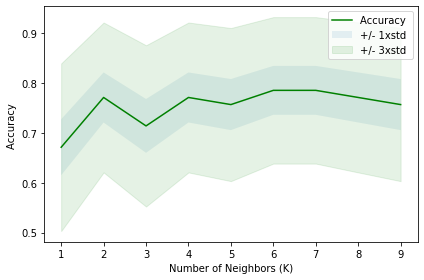

Based on the plot above, k= 6
Value is  0.7857142857142857


In [235]:
#plot model accuracy
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
#print our assessment of the results
# get the index of the maximum value in our array and add 1 for k being one-based value
bestk = np.argmax(mean_acc)+1
print('Based on the plot above, k=',bestk);
knnacc = mean_acc[bestk]
print('Value is ',knnacc)
# save just this model for use later
bestNeigh = KNeighborsClassifier(n_neighbors = bestk).fit(X_train, y_train)


# Decision Tree

In [239]:
# switching back to categorical y target value
#XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, test_size=0.2, random_state=4)
XX_train = X
yy_train = y

#print('Train set:', XX_train.shape, yy_train.shape)
#print('Test set:', XX_test.shape, yy_test.shape)

# create instance of decision tree
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)

# show example data
print(Feature.columns[0:8])
print(XX_train[0:5])

# fit data
loanTree.fit(XX_train, yy_train)

# make predictions
#predTree = loanTree.predict(XX_test)
#print(predTree [0:5])
#print(yy_test [0:5])
#dectreeacc = metrics.accuracy_score(yy_test, predTree)
#print("DecisionTree's Accuracy: ", dectreeacc)

Index(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')
[[ 0.51578458  0.92071769  2.33152555 -0.42056004 -1.20577805 -0.38170062
   1.13639374 -0.86968108]
 [ 0.51578458  0.92071769  0.34170148  2.37778177 -1.20577805  2.61985426
  -0.87997669 -0.86968108]
 [ 0.51578458 -0.95911111 -0.65321055 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.48739188  2.37778177  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.3215732  -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]]


DecisionTreeClassifier(criterion='entropy', max_depth=7)

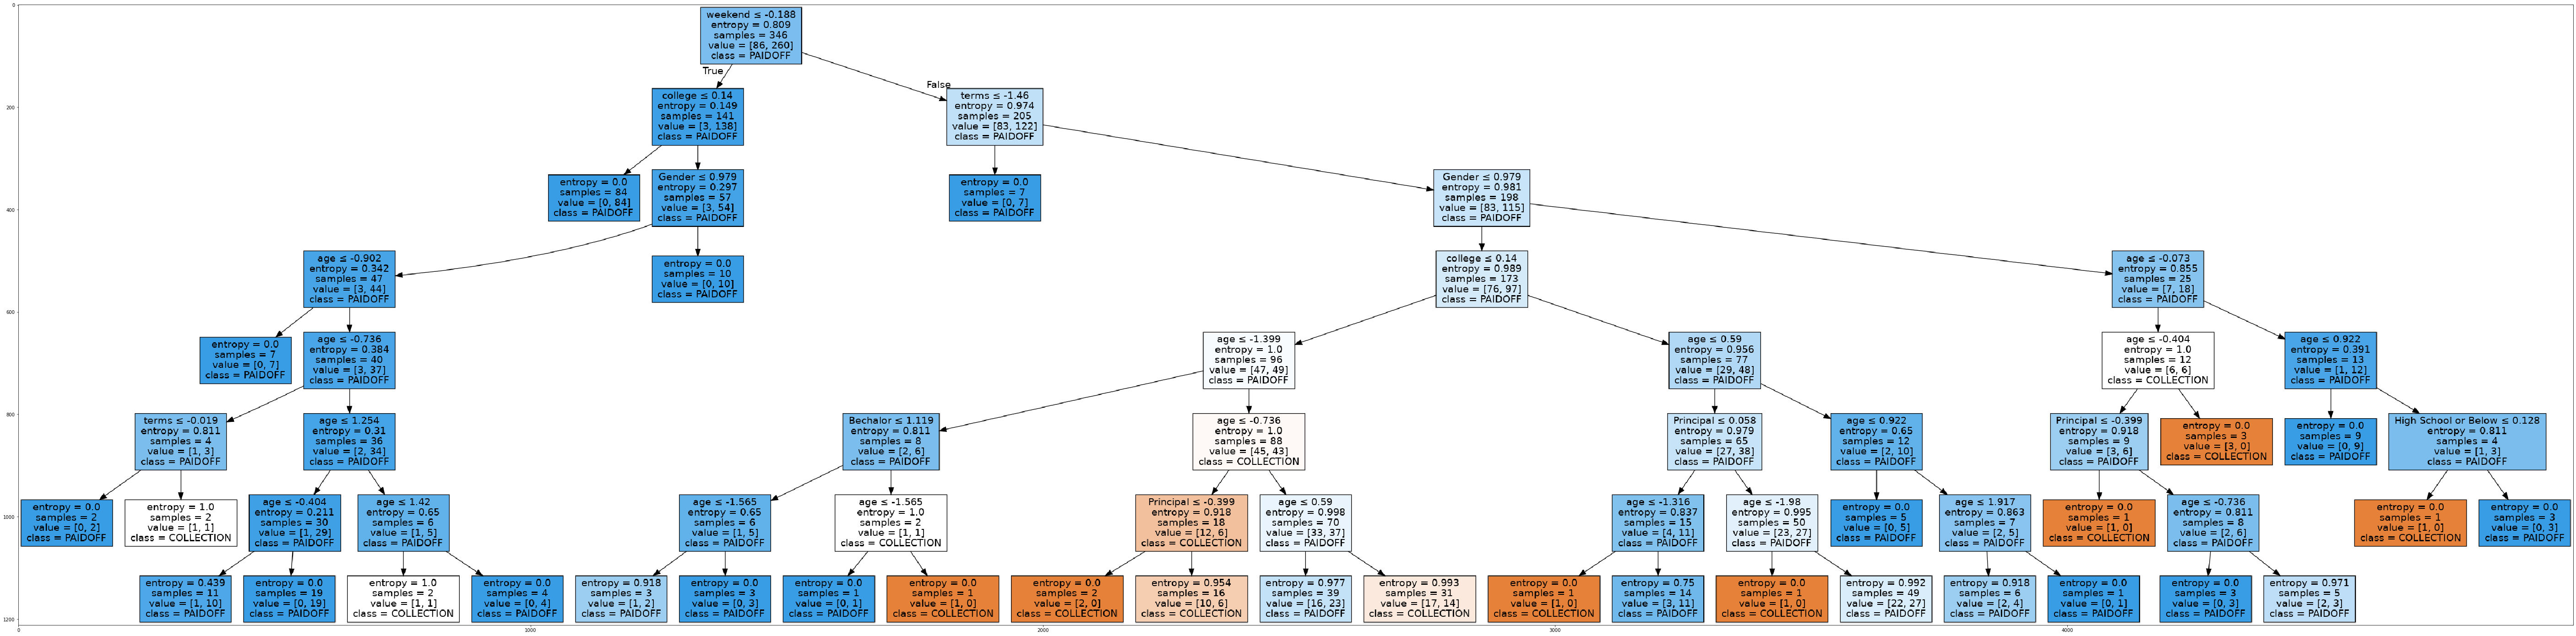

In [240]:
# ensure packages are installed
#!conda install -c conda-forge pydotplus -y (fails)
#!conda install -c conda-forge python-graphviz -y (fails)
#!pip install --user pydotplus (works)
#!pip install --user python-graphviz (fails)

# visualize the tree
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[0:8]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(yy_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [211]:
print("Decision tree accuracy was ",dectreeacc)

Decision tree accuracy was  0.7571428571428571


# Support Vector Machine

In [246]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
# use the binary output loan_state
#X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=4)
clf.fit(X_train, y_train) 
#yhat = clf.predict(X_test)
#yhat [0:5]

SVC()

In [247]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [248]:
from sklearn.metrics import f1_score
# class used older content now obsolete: from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score
print("f1 score: ",f1_score(y_test, yhat, average='weighted')) 
print("jaccard score: ",jaccard_score(y_test, yhat, average=None))

f1 score:  0.7275882012724117
jaccard score:  [0.72727273 0.18181818]


# Logistic Regression

In [271]:
import pylab as pl
import scipy.optimize as opt
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)

In [273]:
lr_yhat = LR.predict(X_test)
lr_yhat_prob = LR.predict_proba(X_test)
lr2_yhat = LR2.predict(X_test)
lr2_yhat_prob = LR2.predict_proba(X_test)

In [275]:
from sklearn.metrics import log_loss
print("LR Log Loss: ", log_loss(y_test, lr_yhat_prob))
print ("LR Classification Report: \n",classification_report(y_test, lr_yhat))
print("LR2 Log Loss: ", log_loss(y_test, lr2_yhat_prob))
print ("LR2 Classification Report: \n",classification_report(y_test, lr2_yhat))


LR Log Loss:  0.5772287609479654
LR Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.84      0.81        55
           1       0.18      0.13      0.15        15

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

LR2 Log Loss:  0.4919963924236358
LR2 Classification Report: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        55
           1       0.00      0.00      0.00        15

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Evaluation using Test set

In [227]:
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [232]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-07 22:11:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-07 22:11:25 (107 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [233]:
test_df = pd.read_csv('loan_test.csv')
print(test_df.head())
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
#print(test_df.head())
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#print(test_df.head())
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#print(test_df.head())
test_Feat = test_df[['Principal','terms','age','Gender','weekend']]
test_Feat = pd.concat([test_Feat,pd.get_dummies(test_df['education'])], axis=1)
test_Feat.drop(['Master or Above'], axis = 1,inplace=True)
print(test_Feat.head())
test_X = test_Feat
print(test_X[0:5])
test_df = test_df.assign(loan_state=test_df['loan_status'])
test_y = test_df['loan_status'].values
test_yy = test_df['loan_state']
test_df['loan_state'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
print(test_df.head())
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
print(test_X[0:5])


   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male  
   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   50       1        0         1                     0   
1        300      7   35       0        1         0                     0   
2       1000

In [279]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

knn_yhat=bestNeigh.predict(test_X)
knn_mean_acc = metrics.accuracy_score(test_yy, knn_yhat)
knn_std_acc = np.std(test_yhat==test_yy)/np.sqrt(knn_yhat.shape[0])
knn_f1_score = f1_score(test_yy, knn_yhat, average='weighted')
knn_jaccard = jaccard_score(test_yy, knn_yhat, average=None)

print("K Nearest Neighbor's (KNN's) Results:")
print("KNN's mean accuracy: ",knn_mean_acc)
print("KNN's std accuracy: ",knn_std_acc)
print("KNN's f1 score: ", knn_f1_score)
print("KNN's jaccard: ", knn_jaccard)
print("")

# make predictions
dectree_predictions = loanTree.predict(test_X)
dectree_dectreeacc = metrics.accuracy_score(test_y, dectree_predictions)

# need to rewrite output as 0 or 1
ls_dict = {'PAIDOFF': 0, 'COLLECTION': 1}
dectree_yhat = [ls_dict[pred] for pred in dectree_predictions]
dectree_f1_score = f1_score(test_yy, dectree_yhat)
dectree_jaccard = jaccard_score(test_yy, dectree_yhat, average=None)

print("Decision Tree's (DT's) Results:")
print("DT's Accuracy: ", test_dectreeacc)
print("DT's f1 score: ",dectree_f1_score)
print("DT's jaccard: ",dectree_jaccard)
print("")

svm_yhat = clf.predict(test_X)
svm_f1_score = f1_score(test_yy, svm_yhat, average='weighted')
svm_jaccard = jaccard_score(test_yy, svm_yhat, average=None)

print("Support Vector Machine's (SVM's) Results:")
print("SVM's f1 score: ",svm_f1_score) 
print("SVM's jaccard score: ",svm_jaccard)
print("")

lr_yhat = LR.predict(test_X)
lr_yhat_prob = LR.predict_proba(test_X)
lr2_yhat = LR2.predict(test_X)
lr2_yhat_prob = LR2.predict_proba(test_X)

lr_f1_score = f1_score(test_yy, lr_yhat, average='weighted')
lr_jaccard = jaccard_score(test_yy, lr_yhat, average=None)
lr_log_loss = log_loss(test_yy, lr_yhat)

lr2_f1_score = f1_score(test_yy, lr2_yhat, average='weighted')
lr2_jaccard = jaccard_score(test_yy, lr2_yhat, average=None)
lr2_log_loss = log_loss(test_yy, lr2_yhat)

print("Logistic Regression liblinear (LR1's) Results:")
print("LR1's f1 score: ",lr_f1_score)
print("LR1's jaccard: ",lr_jaccard)
print("LR1's log loss: ",lr_log_loss)
print("")
print("Logistic Regression sag (LR2's) Results:")
print("LR2's f1 score: ",lr2_f1_score)
print("LR2's jaccard: ",lr2_jaccard)
print("LR2's log loss: ",lr2_log_loss)


K Nearest Neighbor's (KNN's) Results:
KNN's mean accuracy:  0.6851851851851852
KNN's std accuracy:  0.0632025619481797
KNN's f1 score:  0.626541384672668
KNN's jaccard:  [0.67924528 0.05555556]

Decision Tree's (DT's) Results:
DT's Accuracy:  0.7592592592592593
DT's f1 score:  0.43478260869565216
DT's jaccard:  [0.73469388 0.27777778]

Support Vector Machine's (SVM's) Results:
SVM's f1 score:  0.7583503077293734
SVM's jaccard score:  [0.78       0.26666667]

Logistic Regression liblinear (LR1's) Results:
LR1's f1 score:  0.6604267310789049
LR1's jaccard:  [0.73584906 0.06666667]
LR1's log loss:  8.954512391225549

Logistic Regression sag (LR2's) Results:
LR2's f1 score:  0.6304176516942475
LR2's jaccard:  [0.74074074 0.        ]
LR2's log loss:  8.954497583865733


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>